In [3]:
using GLMakie
using Random
using Distributions
using Colors
using LinearAlgebra

step 1 diff0.05486920470744943
step 2 diff0.04094814363453941
step 3 diff0.03152148119625911
step 4 diff0.025295060538457786
step 5 diff0.021200237701554495
step 6 diff0.01848767671770167
step 7 diff0.016670269386303792
step 8 diff0.015437915153864508
step 9 diff0.014592053614052322
step 10 diff0.014003917026315343
step 11 diff0.013589065142439396
step 12 diff0.013291655102657736
step 13 diff0.013074489325782625
step 14 diff0.012912611679562465
step 15 diff0.012789150239731404
step 16 diff0.012692605267702627
step 17 diff0.012615072495555752
step 18 diff0.012551073180051182
step 19 diff0.012496778755109121
step 20 diff0.012449493100716356
step 21 diff0.012407303935733449
step 22 diff0.01236884601905769
step 23 diff0.01233313886516541
step 24 diff0.012299474554177119
step 25 diff0.012267339524622955
step 26 diff0.012236359628114257
step 27 diff0.012206261247850762
step 28 diff0.012176843603458143
step 29 diff0.012147958906798222
step 30 diff0.012119498067708232
step 31 diff0.01209138034

Excessive output truncated after 524300 bytes.


step 14404 diff0.0010608771979547919
step 14405 diff0.0010608361964814415
step 14406 diff0.0010607951992971248
step 14407 diff0.0010607542064070212
step 14408 diff0.001060713217806205
step 14409 diff0.0010606722334962927
step 14410 diff0.0010606312534725331
step 14411 diff0.001060590277738661
step 14412 diff0.001060549306294666
step 14413 diff0.0010605083391336816
step 14414 diff0.001060467376260286
step 14415 diff0.0010604264176724144
step 14416 diff0.0010603854633692389
step 14417 diff0.0010603445133478596
step 14418 diff0.0010603035676108332
step 14419 diff0.0010602626261563906
step 14420 diff0.0010602216889834199
step 14421 diff0.0010601807560898602
step 14422 diff0.001060139827476666
step 14423 diff0.0010600989031448276
step 14424 diff0.001060057983087962
step 14425 diff0.0010600170673119812
step 14426 diff0.0010599761558094964
step 14427 diff0.0010599352485864233
step 14428 diff0.0010598943456372647
step 14429 diff0.0010598534469619236
step 14430 diff0.0010598125525614528
step 1

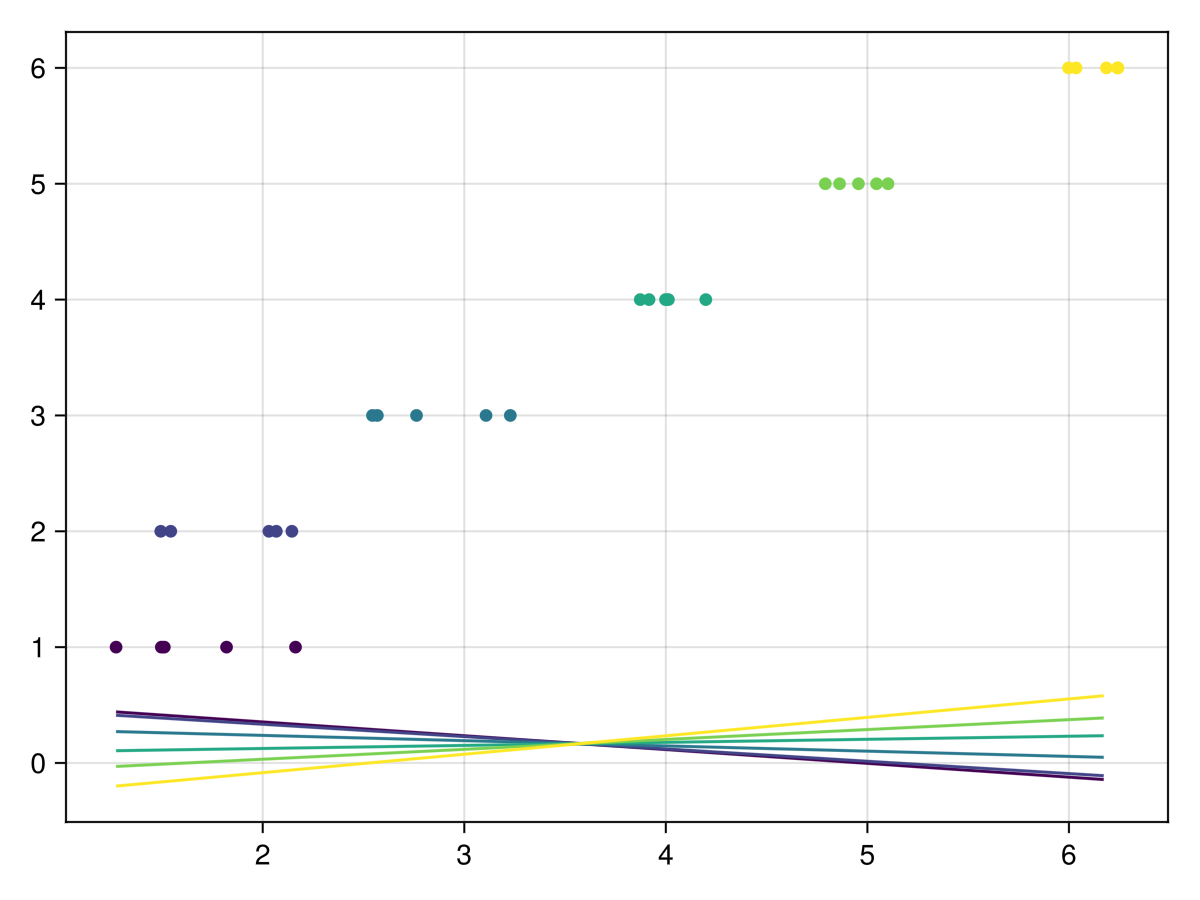

In [13]:
function get_sizes(t, nt)
    n = length(t)
    K = div(length(nt), n) + 1
    return n, K
end

function linreg_t(t, nt)
    n, K = get_sizes(t, nt)
    A = hcat(ones(n*K), vcat(t, nt))
    y = vcat(ones(n), zeros((K-1)*n))
    v = A\y
    return v
end

function display_linregs(ts, nts)
    n, K = get_sizes(ts[1], nts[1])

    fig = Figure()
    ax = Axis(fig[1,1])
    cmap = cgrad(:viridis, length(ts), categorical=true)
    xmin = minimum(vcat(ts[1], nts[1]))
    xmax = maximum(vcat(ts[1], nts[1]))

    for (i, (t, nt)) in enumerate(collect(zip(ts, nts)))
        b,w = linreg_t(t, nt)
        x = xmin:0.1:xmax
        y = b .+ w .* x

        color = cmap[i]
        lines!(x, y, color = color)
        scatter!(t, fill(i, n), color = color)
    end
    return fig
end

function act(v, x)
    b, w = v
    # println("b ",b)
    # println("w ",w, "len ", length(w))
    # println("x ",x, "len ", length(x))

    return b + w * x
end

function s(a, k)
    return exp(a[k]) / sum(exp.(a))
end

function lambda(py)
    return -log(py)
end

function loss(y,p)
    return lambda(p[y])
end

function risk(v, K, x, y)
    loss = 0
    N = length(x)
    for n in 1:N
        a = [act([v[k],v[k+1]],x[n]) for k in 1:2:2*K]
        # py = s(a, y[n])
        # loss += lambda(py)
        a0 = a .- maximum(a)
        loss += -a0[y[n]] + log(sum(exp.(a0)))
    end
    return 1/N * loss
end

function g(v, x, y, K)
    nabla = zeros(2*K)
    N = length(x)
    for n in 1:N
        a = [act([v[k],v[k+1]],x[n]) for k in 1:2:2*K]
        p = exp.(a .- maximum(a))
        p ./= sum(p)
        for j in 1:K
            coeff = p[j] - (y[n] == j ? 1 : 0)
            nabla[2*j-1] += coeff
            nabla[2*j]   += coeff * x[n]
        end
    end
    return nabla ./ N
end
        # for k in 1:K
        #     if y[n] == k
        #         nabla[2*k-1] += s(a, k) - 1
        #         nabla[2*k] += (s(a, k) - 1) * x[n]
        #     else
        #         nabla[2*k-1] += s(a, k)
        #         nabla[2*k] += s(a, k) * x[n]
        #     end
        # end

    # for k in 1:K
    #     # dldb, dldw = 0, zeros(length(x[1]))
    #     dldb, dldw = 0, 0
    #     for n in N
    #         a = [act([v[k],v[k+1]],x[n]) for k in 1:2:2*K]
    #         if y == k
    #             dldb += s(a, k) - 1
    #             dldw += (s(a, k) - 1) * x[n]
    #         else
    #             dldb += s(a, k)
    #             dldw += s(a, k) * x[n]
    #         end
    #     end
    #     push!(nabla, dldb/N, dldw/N)
    # end
    # return nabla

function gd(v0, g, x, y, K, alpha=0.1, delta=0.00001, max_steps=100000)
    v_old = copy(v0)
    for step in 1:max_steps
        v = v_old - alpha * g(v_old, x, y, K)
        diff = norm(v - v_old)
        println("step ", step, " diff",diff)
        if diff < delta
            return v
        end
        v_old = v
    end
    println("max iterations exceeded")
    return v
end

function display_fit_linregs(v, ts)
    n = length(ts[1])

    fig = Figure()
    ax = Axis(fig[1,1])
    cmap = cgrad(:viridis, length(ts), categorical=true)
    xmin = minimum(vcat(ts...))
    xmax = maximum(vcat(ts...))

    for (i, t) in enumerate(ts)
        b,w = v[2*i-1],v[2*i]
        x = xmin:0.1:xmax
        y = b .+ w .* x

        color = cmap[i]
        lines!(x, y, color = color)
        scatter!(t, fill(i, n), color = color)
    end
    return fig
end

n = 5
K = 6

ts  = [ rand(Normal(i, rand()), n)       for i in 1:K]
nts = [ vcat(ts[1:i-1]..., ts[i+1:K]...) for i in 1:K]

x = vcat(ts...)
y = vcat([fill(i,n) for i in 1:K]...)

v = vcat(linreg_t.(ts, nts)...)

vf = gd(v, g, x, y, K)
println(vf)
println(risk(vf, K, x, y))

# fig5 = display_linregs(ts, nts)

fig6 = display_fit_linregs(vf, ts)

$$v = [b_1, w_1, ..., b_N, w_N]$$
$$a(x) = b + w \cdot x$$
$$s(a_k(x)) = \frac{e^{a_k(x)}}{\sum e^{a(x)}}$$

In [ ]:
function hinge_risk(t, nt, b, w)
    n = length(t)
    N = div(length(nt), n) + 1

    ds = vcat(b .+ w .* t - ones(n), b .+ w .* nt - zeros((N-1)*n))
    loss = sum(exp.(ds))
    risk = loss / (N*n)
end

function s(v, k, t, nt)
    n = length(t)
    N = div(length(nt), n) + 1
    
    numer = hinge_risk(t, nt, v[2 * k - 1], v[2 * k])
    denom = sum(hinge_risk(t, nt, v[2 * i - 1], v[2 * i]) for i in 1:N)
    return numer / denom
end

b, w = linreg_t(as, non_as)
hinge_risk(as, non_as, b, w)
s([0,1,1,0,0.5,0.5],1,as,non_as)

v = []
for (k, non_k) in collect(zip(ks, non_ks))
    bk, wk = linreg_t(k, non_k, N)
    push!(v, bk, wk)
end

k=6
mysum = 0
for i in 1:N
    mysum += s(v, i, ks[k], non_ks[k])
    println(s(v, i, ks[k], non_ks[k]))
end
println(mysum)

0.17505828774922666
0.17078557229796557
0.1660605370470901
0.16328124089097787
0.16275726334105645
0.1620570986736833
1.0


expected:
$$\hat{y} = h(\textbf{x}) = \argmax_k p_k = \argmax_k s(a_k(\textbf{x})) = \argmax_k \frac{e^{a_k}}{\sum_{i = 1}^K e^{a_i}}$$
actual:
$$\hat{y} = h(\textbf{x}) \in \argmax_k(a_1(\textbf{x}), ..., a_K(\textbf{x}))$$

$$L(y, \textbf{p}) = \lambda(p_k) = -log(p_k) = -log(s(a_k(\textbf{x}))) = -log(\frac{e^{a_k}}{\sum_{i = 1}^K e^{a_i}})$$

In [ ]:
test = [[num, num+1] for num in 1:2:2*3]

3-element Vector{Vector{Int64}}:
 [1, 2]
 [3, 4]
 [5, 6]

In [ ]:
z = zeros(2)
z .+= [1,2]
z

2-element Vector{Float64}:
 1.0
 2.0

In [ ]:
1 .+ [4,5,6]

3-element Vector{Int64}:
 5
 6
 7

In [ ]:
1 .+ 1

2

In [ ]:
[1,2,3]/2

3-element Vector{Float64}:
 0.5
 1.0
 1.5